In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
from utils import load, plot_sample, train, prepare_submission, get_cnn, get_fc, get_exactly_same_fc_with_blog

from datetime import datetime
import os
import time

import matplotlib.pyplot as pyplot
import tensorflow as tf

In [3]:
os.environ["FTRAIN"] = "/Users/chang12/projects/kaggle/facial-keypoint-detection/training.csv"
os.environ["FTEST"] = "/Users/chang12/projects/kaggle/facial-keypoint-detection/test.csv"

In [4]:
X, y = load()
X_test, _ = load(test=True)

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("X_test.shape == {}; X_test.min == {:.3f}; X_test.max == {:.3f}".format(X_test.shape, X_test.min(), X_test.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

X.shape == (2140, 9216); X.min == 0.000; X.max == 1.000
X_test.shape == (1783, 9216); X_test.min == 0.000; X_test.max == 1.000
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [23]:
num_epoch = 400
name = "imitate_blog_post"

y_pred = train(num_epoch, X, y, X_test, name, get_exactly_same_fc_with_blog)

Epoch:    1	Training Loss: 0.8349220	Elapsed Time(ms):    121
Epoch:    2	Training Loss: 0.5499601	Elapsed Time(ms):     89
Epoch:    3	Training Loss: 0.3906393	Elapsed Time(ms):     91
Epoch:    4	Training Loss: 0.1277537	Elapsed Time(ms):    100
Epoch:    5	Training Loss: 0.1019662	Elapsed Time(ms):     93
Epoch:    6	Training Loss: 0.0935365	Elapsed Time(ms):     94
Epoch:    7	Training Loss: 0.0882352	Elapsed Time(ms):    100
Epoch:    8	Training Loss: 0.0859310	Elapsed Time(ms):     90
Epoch:    9	Training Loss: 0.0832318	Elapsed Time(ms):     93
Epoch:   10	Training Loss: 0.0794783	Elapsed Time(ms):    100
Epoch:   11	Training Loss: 0.0754555	Elapsed Time(ms):     94
Epoch:   12	Training Loss: 0.0714149	Elapsed Time(ms):     99
Epoch:   13	Training Loss: 0.0673182	Elapsed Time(ms):     95
Epoch:   14	Training Loss: 0.0630780	Elapsed Time(ms):     90
Epoch:   15	Training Loss: 0.0585961	Elapsed Time(ms):    100
Epoch:   16	Training Loss: 0.0539015	Elapsed Time(ms):    102
Epoch:  

Epoch:  132	Training Loss: 0.0081752	Elapsed Time(ms):     96
Epoch:  133	Training Loss: 0.0081540	Elapsed Time(ms):     94
Epoch:  134	Training Loss: 0.0081329	Elapsed Time(ms):     92
Epoch:  135	Training Loss: 0.0081121	Elapsed Time(ms):     93
Epoch:  136	Training Loss: 0.0080914	Elapsed Time(ms):     97
Epoch:  137	Training Loss: 0.0080709	Elapsed Time(ms):     95
Epoch:  138	Training Loss: 0.0080506	Elapsed Time(ms):     98
Epoch:  139	Training Loss: 0.0080306	Elapsed Time(ms):     96
Epoch:  140	Training Loss: 0.0080107	Elapsed Time(ms):     95
Epoch:  141	Training Loss: 0.0079909	Elapsed Time(ms):     97
Epoch:  142	Training Loss: 0.0079713	Elapsed Time(ms):     94
Epoch:  143	Training Loss: 0.0079518	Elapsed Time(ms):     99
Epoch:  144	Training Loss: 0.0079326	Elapsed Time(ms):    100
Epoch:  145	Training Loss: 0.0079135	Elapsed Time(ms):     99
Epoch:  146	Training Loss: 0.0078946	Elapsed Time(ms):    106
Epoch:  147	Training Loss: 0.0078758	Elapsed Time(ms):     95
Epoch:  

Epoch:  265	Training Loss: 0.0063902	Elapsed Time(ms):    103
Epoch:  266	Training Loss: 0.0063816	Elapsed Time(ms):     93
Epoch:  267	Training Loss: 0.0063731	Elapsed Time(ms):     95
Epoch:  268	Training Loss: 0.0063646	Elapsed Time(ms):     96
Epoch:  269	Training Loss: 0.0063562	Elapsed Time(ms):     94
Epoch:  270	Training Loss: 0.0063478	Elapsed Time(ms):     93
Epoch:  271	Training Loss: 0.0063394	Elapsed Time(ms):     97
Epoch:  272	Training Loss: 0.0063311	Elapsed Time(ms):     96
Epoch:  273	Training Loss: 0.0063228	Elapsed Time(ms):     96
Epoch:  274	Training Loss: 0.0063146	Elapsed Time(ms):     97
Epoch:  275	Training Loss: 0.0063064	Elapsed Time(ms):     96
Epoch:  276	Training Loss: 0.0062982	Elapsed Time(ms):     95
Epoch:  277	Training Loss: 0.0062901	Elapsed Time(ms):     96
Epoch:  278	Training Loss: 0.0062819	Elapsed Time(ms):     95
Epoch:  279	Training Loss: 0.0062739	Elapsed Time(ms):     98
Epoch:  280	Training Loss: 0.0062658	Elapsed Time(ms):     99
Epoch:  

Epoch:  396	Training Loss: 0.0055293	Elapsed Time(ms):    101
Epoch:  397	Training Loss: 0.0055242	Elapsed Time(ms):     93
Epoch:  398	Training Loss: 0.0055190	Elapsed Time(ms):     90
Epoch:  399	Training Loss: 0.0055139	Elapsed Time(ms):    101
Epoch:  400	Training Loss: 0.0055088	Elapsed Time(ms):     89
model has saved in path: checkpoints/20171214_22:34:53_imitate_blog_post/00400/ckpt


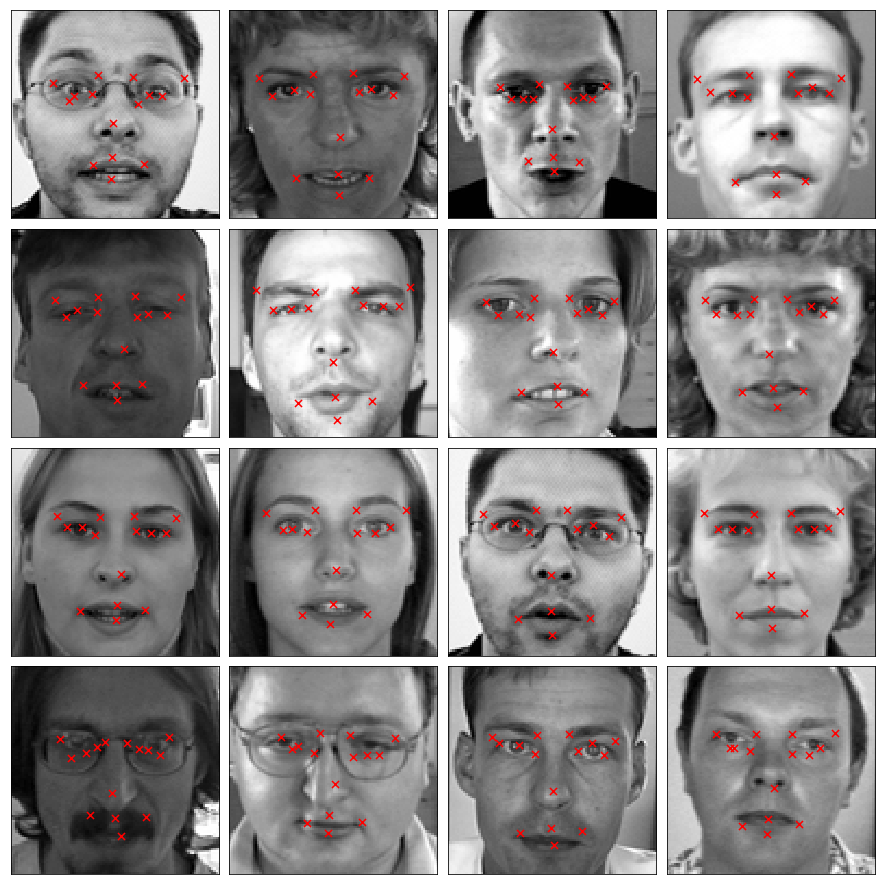

In [14]:
fig = pyplot.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)
    
pyplot.show()

In [24]:
X_test, _ = load(test=True)
submission_csv_path = prepare_submission(X_test, "20171214_22:34:53_imitate_blog_post", 400, get_fc)
print("submission csv is saved at: {}".format(submission_csv_path))

INFO:tensorflow:Restoring parameters from /Users/chang12/Projects/kaggle/facial-keypoint-detection/checkpoints/20171214_22:34:53_imitate_blog_post/00400/ckpt
submission csv is saved at: /Users/chang12/Projects/kaggle/facial-keypoint-detection/submissions/20171214_22:34:53_imitate_blog_post_00400.csv
